In [69]:
# forecast rainfall-pre with random forest
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot


In [70]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
"""
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 

In [71]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

In [72]:
# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = RandomForestRegressor(n_estimators=1000)
#     random_state=0, n_estimators=200, max_depth=None, max_features=1, min_samples_leaf=1, min_samples_split=2, bootstrap=False
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0]

In [73]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = random_forest_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions

In [74]:
# load the dataset
series = read_csv('Mekong_ChauDoc.csv',usecols=[1,2,3,4,5,6,7,8,9,10,11,12,13,14],engine='python')
series.head()

,Luang Prabang,Chieang Saen,NongKhai,Chieng Khan,VienTiean,Mukdahan,KhongCham,Pakse,Stungtreng,Kratie,Kompongcham,Phnompenh Port,Chau Doc
0,4.11,1.10,NaN,NaN,1.00,1.56,NaN,0.95,2.38,6.72,4.23,2.62,NaN
1,3.55,0.85,NaN,NaN,0.64,1.31,NaN,0.67,2.04,5.93,3.22,1.67,NaN
2,3.12,0.78,NaN,NaN,0.24,1.12,NaN,0.50,1.77,5.53,2.72,1.17,NaN
3,3.52,1.14,NaN,NaN,0.63,1.18,NaN,0.59,1.78,5.48,2.38,0.93,NaN
4,3.99,1.62,NaN,NaN,1.15,1.57,NaN,1.06,2.55,6.92,2.87,1.27,NaN


In [79]:
values = series.values
# values = values.astype('float32')
# transform the time series data into supervised learning
data = series_to_supervised(values,1,1)
data.drop(data.columns[[13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,25]], axis=1, inplace=True)
print(data.head())
print(data.shape)
print(type(data))
data=data.to_numpy()
print(type(data))
print("---------------") 

     var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
229       4.08       1.69       1.62       3.76       1.20       1.58   
230       3.39       1.41       1.12       2.94       0.89       1.29   
231       3.02       1.25       0.85       2.44       0.70       1.17   
232       3.29       1.60       1.08       2.56       0.93       1.18   
233       3.88       1.99       1.81       3.39       1.53       1.63   

     var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
229       2.07       1.06       2.29        6.94        3.54        1.51   
230       1.74       0.77       2.04        6.32        2.85        1.16   
231       1.58       0.65       1.90        5.97        2.47        0.97   
232       1.57       0.65       1.85        5.85        2.32        0.90   
233       2.10       1.14       2.25        6.84        3.42        1.42   

     var13(t-1)  
229        0.83  
230        0.67  
231        0.43  
232        0.39  
233        0.3

>expected=0.9, predicted=0.7
>expected=0.8, predicted=0.5
>expected=0.7, predicted=0.4
>expected=0.6, predicted=0.5
>expected=0.7, predicted=0.7
>expected=1.4, predicted=1.7
>expected=2.6, predicted=2.7
>expected=2.5, predicted=2.6
>expected=2.5, predicted=2.6
>expected=1.7, predicted=1.8
>expected=1.2, predicted=0.9
>expected=0.9, predicted=0.8
>expected=0.7, predicted=0.7
>expected=0.7, predicted=0.5
>expected=0.7, predicted=0.9
>expected=0.6, predicted=0.4
>expected=0.5, predicted=0.5
>expected=0.7, predicted=0.7
>expected=1.4, predicted=1.5
>expected=1.7, predicted=1.8
>expected=1.8, predicted=1.9
>expected=1.4, predicted=1.2
>expected=1.0, predicted=0.8
>expected=0.7, predicted=0.6
>expected=0.8, predicted=0.6
>expected=0.6, predicted=0.4
>expected=0.5, predicted=0.4
>expected=0.5, predicted=0.4
>expected=0.6, predicted=0.5
>expected=1.1, predicted=1.0
>expected=1.2, predicted=1.3
>expected=1.9, predicted=1.9
>expected=2.4, predicted=2.6
>expected=2.0, predicted=1.9
>expected=1.4,

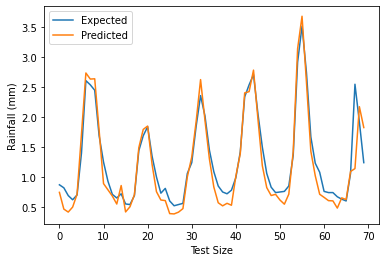

In [80]:
# evaluate
mae, y, yhat = walk_forward_validation(data, int(len(series) * 0.1))
# print(yhat)
print('MAE: %.3f' % mae) 
# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.xlabel('Test Size')
pyplot.ylabel('Rainfall (mm)')
pyplot.show()

In [90]:
# construct an input for a new prediction
row=[5.18, 2.09, 2.49, 2.00, 2.09, 2.09, 2.57, 1.55, 2.69, 8.14, 4.68, 2.12]
row=asarray([row])
# print(type(row))
trainX, trainy = data[:, :-1], data[:, -1]
# fit model
model = RandomForestRegressor(n_estimators=1000)
model.fit(trainX, trainy)
# make a one-step prediction
yhat1 = model.predict(row)
print('Input: %s, Predicted-ChauDoc: %.3f' % (row, yhat1[0]) +' mm')

Input: [[5.18 2.09 2.49 2.   2.09 2.09 2.57 1.55 2.69 8.14 4.68 2.12]], Predicted-ChauDoc: 0.976 mm
